
# Wikipedia Article Traffic Analysis for Rare Diseases

This notebook analyzes the monthly pageview traffic of a subset of Wikipedia articles related to rare diseases from July 1, 2015, through September 30, 2024. The dataset is obtained using the [Wikimedia REST API](https://www.mediawiki.org/wiki/Wikimedia_REST_API). The API documentation, [pageviews/per-article](https://wikimedia.org/api/rest_v1/#/Pageviews%20data), covers additional details that may be helpful when trying to use or understand this example. The project follows best practices for open scientific research and consists of data acquisition, analysis, and visualization.

## License
This code below was partailly developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.3 - August 16, 2024



In [1]:
# These are standard python modules
import json, time, urllib.parse, pandas as pd
#
# The 'requests' module is not a standard Python module. You will need to install this with pip/pip3 if you do not already have it
import requests

In [2]:
from google.colab import drive
drive.mount('/content/drive')
csv_file_path = '/content/drive/My Drive/DATA 512/rare-disease_cleaned.AUG.2024.csv'
rare_diseases_df = pd.read_csv(csv_file_path)

ARTICLE_TITLES = rare_diseases_df['disease'].tolist()


Mounted at /content/drive


## Data Acquisition

I used the Wikimedia Analytics Pageviews [API](https://www.mediawiki.org/wiki/Wikimedia_REST_API) to collect pageview data for articles related to rare diseases. The API provides monthly traffic data starting from July 2015. Three types of data were collected:
* **Desktop Access**: Pageviews on the desktop version of Wikipedia.
* **Mobile Access**: Sum of pageviews on the mobile app and mobile web versions.
* **Cumulative Access**: Total of both desktop and mobile access.

The data was saved as JSON files in the following format:
* `rare-disease_monthly_mobile_201507-202409.json`
* `rare-disease_monthly_desktop_201507-202409.json`
* `rare-disease_monthly_cumulative_201507-202409.json`


In [3]:
#########
#
#    CONSTANTS
#

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error
REQUEST_HEADERS = {
    'User-Agent': '<apeled@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2024',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
# ARTICLE_TITLES = [ 'Bison', 'Northern flicker', 'Red squirrel', 'Chinook salmon', 'Horseshoe bat' ]

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # start and end dates need to be set
    "end":         "2024093000"    # this is likely the wrong end date
}


The API request will be made using one procedure. The idea is to make this reusable. The procedure is parameterized, but relies on the constants above for the important parameters. The underlying assumption is that this will be used to request data for a set of article pages. Therefore the parameter most likely to change is the article_title.


### API Request Function

Here the `request_pageviews_per_article` function sends a request to the Wikimedia API to retrieve monthly pageview data for a specified article. The function takes the article title and access type as input, constructs a request URL, and returns the JSON response containing the data.


In [7]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_pageviews_per_article(article_title = None,
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT,
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS,
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'))
    request_template['article'] = article_title_encoded

    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)

    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

def request_pageviews_per_article(article_title, access_type):
    request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE.copy()
    request_template['article'] = article_title
    request_template['access'] = access_type

    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ', '_'))
    request_template['article'] = article_title_encoded

    # Corrected URL construction
    request_url = f"{API_REQUEST_PAGEVIEWS_ENDPOINT}{API_REQUEST_PER_ARTICLE_PARAMS.format(**request_template)}"

    try:
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=REQUEST_HEADERS)
        return response.json()
    except Exception as e:
        print(f"Error fetching data for {article_title}: {e}")
        return None



In [31]:
# Dictionaries to store data
mobile_data = {}
desktop_data = {}
cumulative_data = {}

for article in ARTICLE_TITLES:
    print(f"Getting pageview data for: {article}")

    # Get desktop data
    desktop_views = request_pageviews_per_article(article, "desktop")
    if desktop_views and 'items' in desktop_views:
        # Remove 'access' field from each item
        desktop_data[article] = [
            {
                'project': item.get('project'),
                'agent': item.get('agent'),
                'timestamp': item['timestamp'],
                'views': item['views']
            }
            for item in desktop_views['items']
        ]

    # Get mobile-app and mobile-web data, then sum them
    mobile_app_views = request_pageviews_per_article(article, "mobile-app")
    mobile_web_views = request_pageviews_per_article(article, "mobile-web")

    if mobile_app_views and 'items' in mobile_app_views and mobile_web_views and 'items' in mobile_web_views:
        # Initialize monthly data sum
        monthly_mobile_data = {}
        for item in mobile_app_views['items']:
            month = item['timestamp']
            if month not in monthly_mobile_data:
                monthly_mobile_data[month] = {
                    'project': item.get('project'),
                    'agent': item.get('agent'),
                    'timestamp': month,
                    'views': 0  # Initialize views to sum up
                }
            monthly_mobile_data[month]['views'] += item['views']

        for item in mobile_web_views['items']:
            month = item['timestamp']
            if month not in monthly_mobile_data:
                monthly_mobile_data[month] = {
                    'project': item.get('project'),
                    'agent': item.get('agent'),
                    'timestamp': month,
                    'views': 0  # Initialize views to sum up
                }
            monthly_mobile_data[month]['views'] += item['views']

        # Convert to list of dictionaries for storage, excluding 'access' field
        mobile_data[article] = list(monthly_mobile_data.values())

    # Aggregate cumulative data (desktop + mobile)
    if article in desktop_data and article in mobile_data:
        cumulative_data[article] = []
        desktop_views_dict = {item['timestamp']: item for item in desktop_data[article]}
        for item in mobile_data[article]:
            month = item['timestamp']
            mobile_views = item['views']
            if month in desktop_views_dict:
                desktop_views = desktop_views_dict[month]['views']
            else:
                desktop_views = 0

            # Create cumulative entry
            cumulative_entry = {
                'project': item['project'],
                'agent': item['agent'],
                'timestamp': month,
                'views': mobile_views + desktop_views
            }
            cumulative_data[article].append(cumulative_entry)

# Save data to JSON files on Google Drive
save_path = '/content/drive/My Drive/DATA 512/'

with open(f'{save_path}rare-disease_monthly_mobile_201507-202409.json', 'w') as f:
    json.dump(mobile_data, f)

with open(f'{save_path}rare-disease_monthly_desktop_201507-202409.json', 'w') as f:
    json.dump(desktop_data, f)

with open(f'{save_path}rare-disease_monthly_cumulative_201507-202409.json', 'w') as f:
    json.dump(cumulative_data, f)

print("Data acquisition complete and saved to JSON files.")


Getting pageview data for: Klinefelter syndrome
Getting pageview data for: Aarskog–Scott syndrome
Getting pageview data for: Abetalipoproteinemia
Getting pageview data for: MT-TP
Getting pageview data for: Ablepharon macrostomia syndrome
Getting pageview data for: Acanthocheilonemiasis
Getting pageview data for: Acanthosis nigricans
Getting pageview data for: Aceruloplasminemia
Getting pageview data for: Megaesophagus
Getting pageview data for: Achard–Thiers syndrome
Getting pageview data for: Achondrogenesis
Getting pageview data for: Achondroplasia
Getting pageview data for: Dwarfism
Getting pageview data for: Osteochondrodysplasia
Getting pageview data for: Fibroblast growth factor receptor 3
Getting pageview data for: Vestibular schwannoma
Getting pageview data for: Brain tumor
Getting pageview data for: Acquired generalized lipodystrophy
Getting pageview data for: Barraquer–Simons syndrome
Getting pageview data for: Acrodermatitis enteropathica
Getting pageview data for: Zinc defi

In [34]:
# Define the path for saving files on Google Drive
save_path = '/content/drive/My Drive/DATA 512/'

# Save data to JSON files on Google Drive
with open(f'{save_path}rare-disease_monthly_mobile_201507-202409.json', 'w') as f:
    json.dump(mobile_data, f)

with open(f'{save_path}rare-disease_monthly_desktop_201507-202409.json', 'w') as f:
    json.dump(desktop_data, f)

with open(f'{save_path}rare-disease_monthly_cumulative_201507-202409.json', 'w') as f:
    json.dump(cumulative_data, f)

print("Data acquisition complete and saved to JSON files on Google Drive.")


Data acquisition complete and saved to JSON files on Google Drive.


## Data Processing

Here I loaded the JSON files into pandas DataFrames for easier manipulation. The data was then grouped by article titles to calculate average and peak page views, as well as the total number of months of data available for each article.


In [35]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Define the path where JSON files are stored on my google drive
data_path = '/content/drive/My Drive/DATA 512/'

# Load files
with open(f'{data_path}rare-disease_monthly_mobile_201507-202409.json', 'r') as f:
    mobile_data = json.load(f)

with open(f'{data_path}rare-disease_monthly_desktop_201507-202409.json', 'r') as f:
    desktop_data = json.load(f)

# Convert JSON data into dataframes
def json_to_df(data):
    records = []
    for article, views in data.items():
        for entry in views:
            records.append({'article': article, 'timestamp': entry['timestamp'], 'views': entry['views']})
    return pd.DataFrame(records)

mobile_df = json_to_df(mobile_data)
desktop_df = json_to_df(desktop_data)

# Convert timestamp to datetime and sort
mobile_df['timestamp'] = pd.to_datetime(mobile_df['timestamp'], format='%Y%m%d%H')
desktop_df['timestamp'] = pd.to_datetime(desktop_df['timestamp'], format='%Y%m%d%H')

# Group data by articles to get average views
mobile_avg_views = mobile_df.groupby('article')['views'].mean()
desktop_avg_views = desktop_df.groupby('article')['views'].mean()


### Maximum and Minimum Average Page Views

This plot shows the time series of monthly page views for the Wikipedia articles with the highest and lowest average page views over the specified time period (July 2015 - September 2024). The graph has four lines representing:
* **Max Mobile**: The article with the highest average page views on mobile access.
* **Min Mobile**: The article with the lowest average page views on mobile access.
* **Max Desktop**: The article with the highest average page views on desktop access.
* **Min Desktop**: The article with the lowest average page views on desktop access.

The purpose of this visualization is to identify and compare the trends in user engagement for the most and least viewed articles across different access types. By observing these trends, we can better understand how the popularity of these articles varies over time and across platforms.


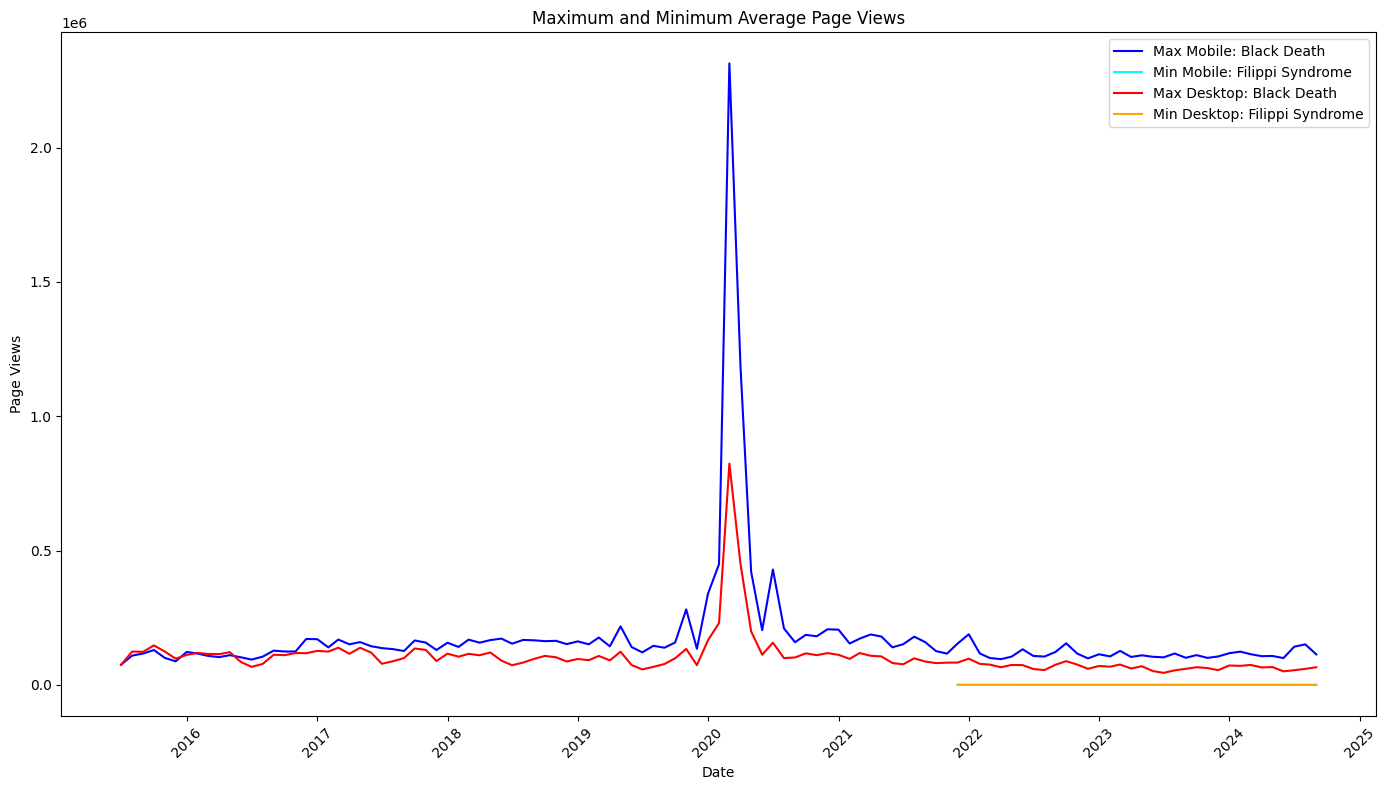

In [36]:
# Find articles with max and min average views
max_mobile_article = mobile_avg_views.idxmax()
min_mobile_article = mobile_avg_views.idxmin()
max_desktop_article = desktop_avg_views.idxmax()
min_desktop_article = desktop_avg_views.idxmin()

# Extract time series data for the articles found
max_mobile_df = mobile_df[mobile_df['article'] == max_mobile_article]
min_mobile_df = mobile_df[mobile_df['article'] == min_mobile_article]
max_desktop_df = desktop_df[desktop_df['article'] == max_desktop_article]
min_desktop_df = desktop_df[desktop_df['article'] == min_desktop_article]

# Plotting the data
plt.figure(figsize=(14, 8))

# Mobile max and min
plt.plot(max_mobile_df['timestamp'], max_mobile_df['views'], label=f'Max Mobile: {max_mobile_article}', color='blue')
plt.plot(min_mobile_df['timestamp'], min_mobile_df['views'], label=f'Min Mobile: {min_mobile_article}', color='cyan')

# Desktop max and min
plt.plot(max_desktop_df['timestamp'], max_desktop_df['views'], label=f'Max Desktop: {max_desktop_article}', color='red')
plt.plot(min_desktop_df['timestamp'], min_desktop_df['views'], label=f'Min Desktop: {min_desktop_article}', color='orange')

# Formatting the plot
plt.title('Maximum and Minimum Average Page Views')
plt.xlabel('Date')
plt.ylabel('Page Views')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot as a PNG image
plt.savefig(f'{data_path}max_min_avg_page_views.png', format='png')
plt.show()


### Top 10 Peak Page Views

This plot displays the time series of the top 10 Wikipedia articles based on their highest single-month page views for both mobile and desktop access. The articles were ranked according to the highest peak views recorded during the entire analysis period, and the top 10 for each access type were plotted.

* The **dashed lines** represent mobile access, and the **solid lines** represent desktop access.
* Each line corresponds to a unique article, showing how its page views change over time.

This visualization helps identify which articles experienced significant spikes in page views and when these spikes occurred. It can provide insights into events or factors that led to increased interest in these articles, such as public health awareness campaigns, media coverage, or other events relevant to rare diseases.


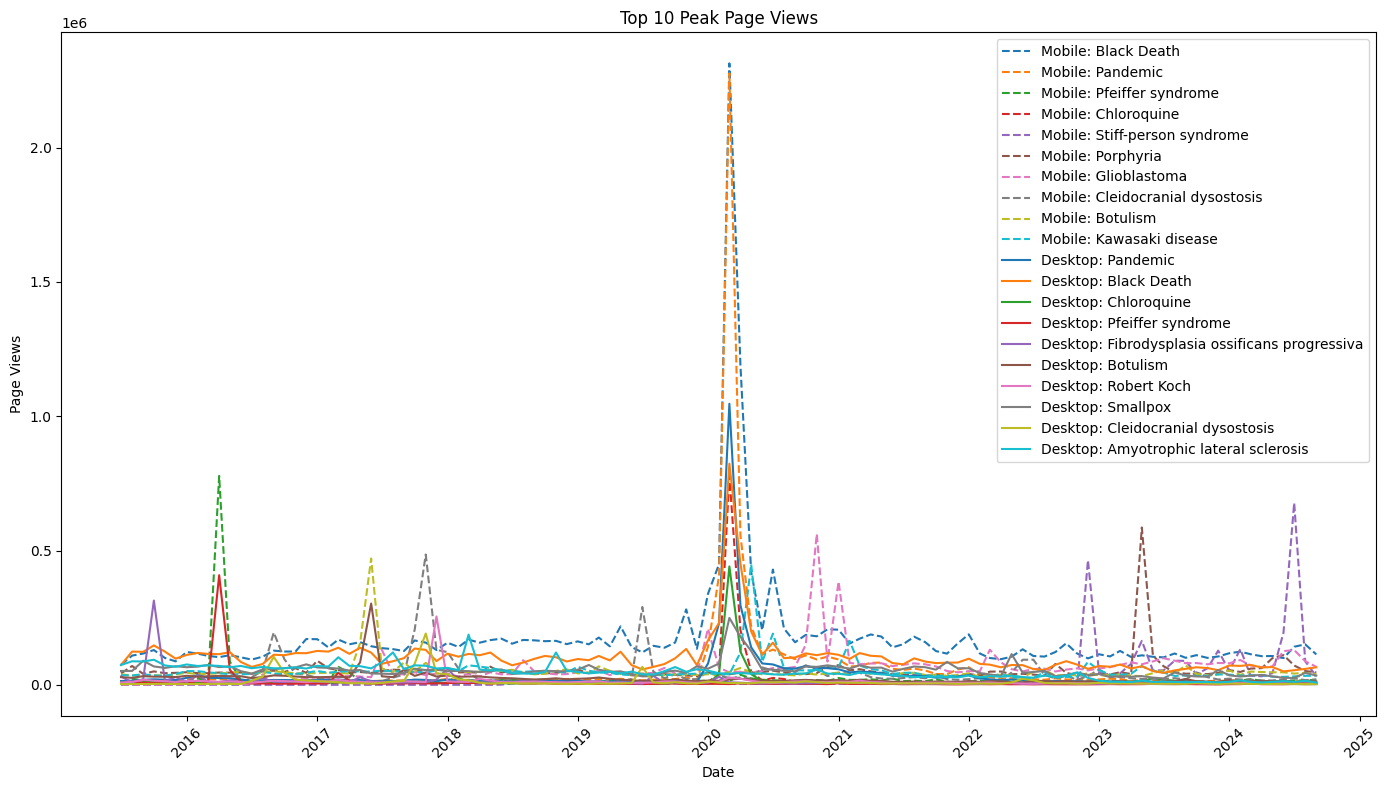

In [37]:
### 2. Top 10 Peak Page Views Graph
# Find the peak page views for each article
mobile_peak_views = mobile_df.groupby('article')['views'].max()
desktop_peak_views = desktop_df.groupby('article')['views'].max()

# Get the top 10 articles by peak views for each access type
top_10_mobile_articles = mobile_peak_views.nlargest(10).index
top_10_desktop_articles = desktop_peak_views.nlargest(10).index

# Extract time series data for the top articles
top_mobile_df = mobile_df[mobile_df['article'].isin(top_10_mobile_articles)]
top_desktop_df = desktop_df[desktop_df['article'].isin(top_10_desktop_articles)]

# Plotting the data
plt.figure(figsize=(14, 8))

# Mobile top 10
for article in top_10_mobile_articles:
    article_df = top_mobile_df[top_mobile_df['article'] == article]
    plt.plot(article_df['timestamp'], article_df['views'], label=f'Mobile: {article}', linestyle='--')

# Desktop top 10
for article in top_10_desktop_articles:
    article_df = top_desktop_df[top_desktop_df['article'] == article]
    plt.plot(article_df['timestamp'], article_df['views'], label=f'Desktop: {article}')

# Formatting the plot
plt.title('Top 10 Peak Page Views')
plt.xlabel('Date')
plt.ylabel('Page Views')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot as a PNG image
plt.savefig(f'{data_path}top_10_peak_page_views.png', format='png')
plt.show()


### Fewest Months of Data

This plot shows the time series of the 10 Wikipedia articles with the fewest months of available data for both desktop and mobile access. These articles likely represent those with shorter histories on Wikipedia or those that have become less relevant over time.

* The **dashed lines** represent mobile access, and the **solid lines** represent desktop access.
* Each line corresponds to a unique article, indicating the months during which page view data was available.

The purpose of this visualization is to highlight articles that have inconsistent or limited data. By identifying these articles, we can understand which topics may need more consistent tracking or possibly indicate articles that were newly created or removed during the observation period.


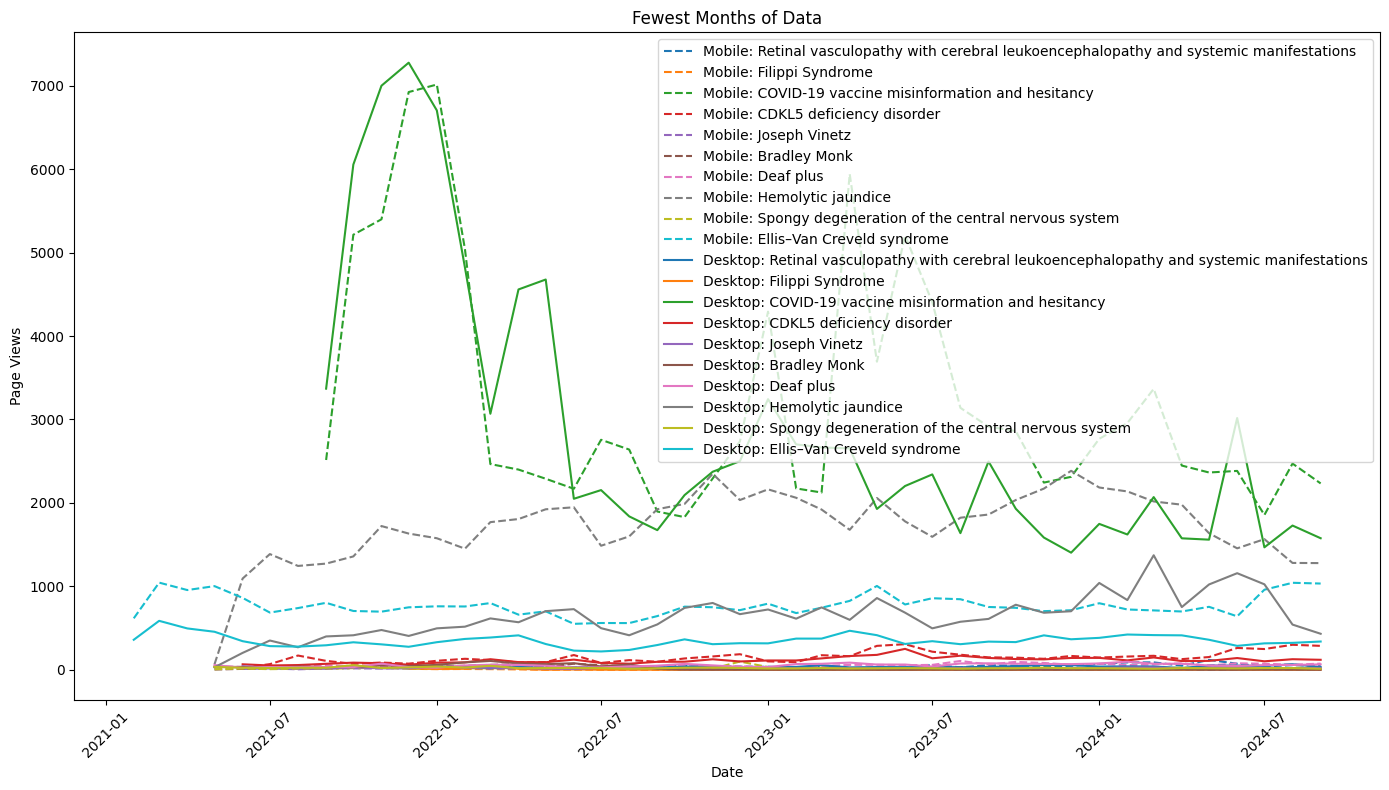

In [38]:
### 3. Fewest Months of Data Graph
# Count number of months of data for each article
mobile_months_count = mobile_df.groupby('article')['timestamp'].nunique()
desktop_months_count = desktop_df.groupby('article')['timestamp'].nunique()

# Get the 10 articles with the fewest months of data for each access type
fewest_mobile_articles = mobile_months_count.nsmallest(10).index
fewest_desktop_articles = desktop_months_count.nsmallest(10).index

# Extract time series data for the articles with the fewest data
fewest_mobile_df = mobile_df[mobile_df['article'].isin(fewest_mobile_articles)]
fewest_desktop_df = desktop_df[desktop_df['article'].isin(fewest_desktop_articles)]

# Plotting the data
plt.figure(figsize=(14, 8))

# Mobile fewest months
for article in fewest_mobile_articles:
    article_df = fewest_mobile_df[fewest_mobile_df['article'] == article]
    plt.plot(article_df['timestamp'], article_df['views'], label=f'Mobile: {article}', linestyle='--')

# Desktop fewest months
for article in fewest_desktop_articles:
    article_df = fewest_desktop_df[fewest_desktop_df['article'] == article]
    plt.plot(article_df['timestamp'], article_df['views'], label=f'Desktop: {article}')

# Formatting the plot
plt.title('Fewest Months of Data')
plt.xlabel('Date')
plt.ylabel('Page Views')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot as a PNG image
plt.savefig(f'{data_path}fewest_months_data.png', format='png')
plt.show()
